In [96]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

#TODO: this should be 224 if we want to use mobilenet
target_shape = (200, 200)

In [ ]:
##load the dataset


In [97]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [109]:
# Load images into arrays
import pathlib

#specify a maximum how many pair that can be made pr class (value is for both positive and negative pairs )

def load_images(path):
    img_array_data = []
    data_dir = pathlib.Path(path)
    image_count = len(list(data_dir.glob('*/*.jpg')) + list(data_dir.glob('*/*.jpeg')) + list(data_dir.glob('*/*.png')))
    folders = [x for x in data_dir.iterdir() if x.is_dir()]
    for i, folder in enumerate(folders):
        img_array_data.append([])

        for j, img in enumerate(folder.iterdir()):
        
            img_array_data[i].append(img)
            
    return img_array_data


def load_images_v2(path):
    data_dir = os.listdir(path)
    img_array_data = []
    
    folders = data_dir#[x for x in data_dir]
    for i, dir_path in enumerate(folders):
        img_array_data.append([])

        for j, img in enumerate(os.listdir(path + "/"+dir_path)):
        
            img_array_data[i].append(path + "/"+dir_path+"/"+img)
            
    return img_array_data





#test_data = load_images("./data/tiered_imagenet/test")

#val_data = load_images("./data/tiered_imagenet/val")


def get_anchor_and_positives(images, max_pairs, max_pairs_per_class):
    anchor_images, positive_images = [],  []
    should_break = False
    should_terminate = False
    
    for i, array in enumerate(images):
        if(should_terminate):
            print("Terminating with a class count of: ", i-1)
            break
        for j in range(len(array)-1):
            if(should_break):
                should_break = False
                break
            
            for k in range(len(array)-1):
            
                
                
               
                anchor_images.append(images[i][k])
                positive_images.append(images[i][(k+j+1)% len(array)])
                if(len(anchor_images) >= max_pairs): 
                    print("Terminating with a pair count of: ", (i+1)*(j+1)*(k+1))
                    should_terminate = True
                    should_break = True
                    break
                if((j+1)*(k+1) >= max_pairs_per_class):
                    should_break = True
                    break                
                
    if(not should_terminate):
        print("Terminating with a class count of: ", str(len(images)))         
    return anchor_images, positive_images

def get_anchor_positives_negatives(images, max_pairs):
    anchor_images, positive_images, negative_images = [], [], []

    should_terminate = False

    for i, array in enumerate(images):
        if(should_terminate):
            break
        for j in range(len(array)-1):
            if(should_terminate):
                break
            for k in range(len(array)-1):
                anchor_images.append(images[i][k])
                positive_images.append(images[i][(k+j+1)% len(array)])
                negative_images.append(images[(i + 1)%len(images)][k % len(images[(i + 1)%len(images)])])
                if(len(anchor_images) >= max_pairs): 
                    print("Terminating with a pair count of: " + str(len(anchor_images)))
                    should_terminate = True
                    break
    return anchor_images, positive_images, negative_images


#anchor_images, positive_images = get_anchor_n_positives(test_data)
#anchor_images, positive_images = get_anchor_n_positives(val_data)



#print("train samples: ", len(train_data))
#print("validation samples: ",len(val_data))
#print("test samples: ", len(test_data))

#unison_shuffled_copies(train_data, train_labels)
#unison_shuffled_copies(test_data, test_labels)
#unison_shuffled_copies(val_data, val_labels)

In [99]:
base_path = r"D:\TrainingImages\tiered_imagenet"

data = []
data.extend(load_images_v2(base_path+"/train"))
data.extend(load_images_v2(base_path+"/val"))
# data.extend(load_images_v2(base_path+"/test"))
print("Maximum Available Classes: " + str(len(data)))
anchor_images, positive_images = get_anchor_and_positives(data, 3000, 10)
pair_count = len(anchor_images)
print(pair_count)




Maximum Available Classes: 448
Terminating with a pair count of:  3000
Terminating with a class count of:  299
3000


In [100]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(len(list(dataset)) * 0.8))
val_and_test = dataset.skip(round(len(list(dataset)) * 0.8))
val_dataset = val_and_test.take(round(len(list(val_and_test)) * 0.5))
test_dataset = val_and_test.skip(round(len(list(val_and_test)) * 0.5))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

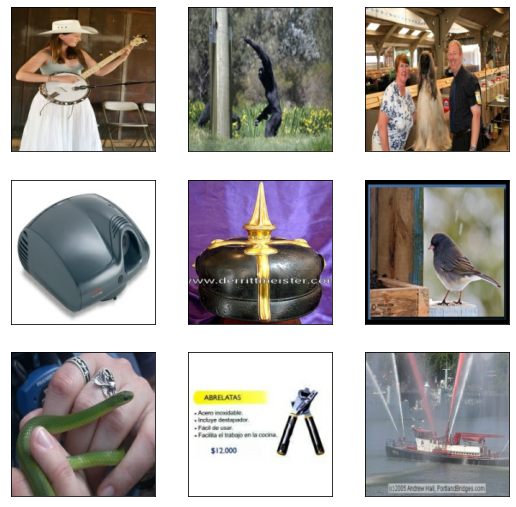

In [65]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [15]:
#TODO: this should be mobilenet

base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

#TODO: consider using anohter flattening layer
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94781440/94765736 [==============================] - 46s 0us/step


In [16]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [17]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [18]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
75/75 [==============================] - 101s 1s/step - loss: 0.5472 - val_loss: 0.4675
Epoch 2/10
75/75 [==============================] - 81s 1s/step - loss: 0.4738 - val_loss: 0.4738
Epoch 3/10
75/75 [==============================] - 89s 1s/step - loss: 0.4680 - val_loss: 0.4385
Epoch 4/10
75/75 [==============================] - 92s 1s/step - loss: 0.4583 - val_loss: 0.4304
Epoch 5/10
75/75 [==============================] - 82s 1s/step - loss: 0.4438 - val_loss: 0.4405
Epoch 6/10
75/75 [==============================] - 85s 1s/step - loss: 0.4332 - val_loss: 0.3983
Epoch 7/10
75/75 [==============================] - 88s 1s/step - loss: 0.4280 - val_loss: 0.4094
Epoch 8/10
75/75 [==============================] - 89s 1s/step - loss: 0.4133 - val_loss: 0.3940
Epoch 9/10
75/75 [==============================] - 94s 1s/step - loss: 0.4228 - val_loss: 0.4009
Epoch 10/10
75/75 [==============================] - 94s 1s/step - loss: 0.4123 - val_loss: 0.3914


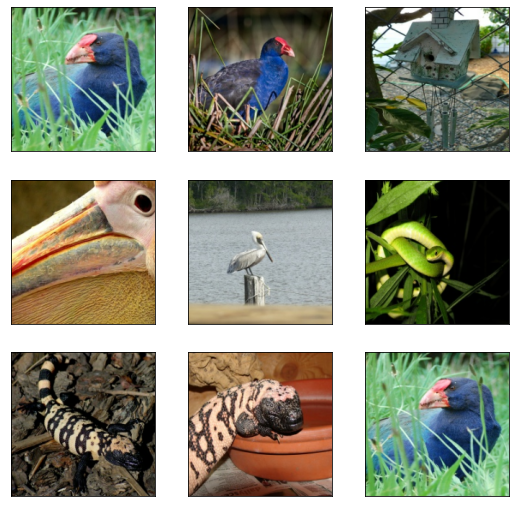

In [21]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [95]:
test_img_1 = preprocess_image(r".\data\dataset\radcliffe_camera\radcliffe_camera_000522.jpg")
print(test_img_1)
test_img_1 =+ np.expand_dims(test_img_1, axis=0)
test_img_2 = preprocess_image(r".\data\dataset\christ_church\christ_church_000996.jpg")
test_img_2 =+ np.expand_dims(test_img_2, axis=0)

em = embedding(resnet.preprocess_input(test_img_1))
em2 = embedding(resnet.preprocess_input(test_img_2))

cosine_similarity = metrics.CosineSimilarity()

lll = cosine_similarity(em, em2)
print("Similarity:", str(lll.numpy())[4:6])

tf.Tensor(
[[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 ...

 [[0.49610132 0.452862   0.31771713]
  [0.52650964 0.49034497 0.34462687]
  [0.5023915  0.46337205 0.3272936 ]
  ...
  [0.66164696 0.6338429  0.5312152 ]
  [0.6764002  0.6334038  0.5308392 ]
  [0.65579623 0.63270575 0.51067454]]

 [[0.52831364 0.47854435 0.37253195]
  [0.514927   0.48353267 0

In [163]:
# Predict the embedding of the test dataset
images = load_images_v2(base_path+"/test")

print("images loaded")

from dataclasses import dataclass

@dataclass
class OutputSet:
    # img1: np.ndarray
    # img2: np.ndarray
    label: int
    similarity: float
    # negative_similarity: float

min_sim = 1
max_sim = 0

test_anchor_images, test_positive_images, test_negative_images = get_anchor_positives_negatives(images, 20)

pos_similarity = []
neg_similarity = []

similarities = []



images loaded
Terminating with a pair count of: 20


In [152]:
def normalize(x, current_min, current_max, des_min = 0, des_max = 1):
    return (x - current_min) / (current_max - current_min) * (des_max - des_min) + des_min

In [171]:
import keras.backend as K

def euclidean_distance(feature_1, feature_2):
    return K.sqrt(K.sum(K.square(feature_1 - feature_2), axis=1, keepdims=True))[0][0]

for i in range(len(test_anchor_images)):
    
    pre_anchor = preprocess_image(test_anchor_images[i])
    pre_positive = preprocess_image(test_positive_images[i])
    pre_negative = preprocess_image(test_negative_images[i])

    pre_anchor += np.expand_dims(pre_anchor, axis=0)
    pre_positive += np.expand_dims(pre_positive, axis=0)
    pre_negative += np.expand_dims(pre_negative, axis=0)

    feature_anchor = embedding(resnet.preprocess_input(pre_anchor))
    feature_positive = embedding(resnet.preprocess_input(pre_positive))
    feature_negative = embedding(resnet.preprocess_input(pre_negative))

    # positive_similarity = metrics.CosineSimilarity()(feature_anchor, feature_positive)
    # negative_similarity = metrics.CosineSimilarity()(feature_anchor, feature_negative)

    positive_similarity = euclidean_distance(feature_anchor, feature_positive)
    negative_similarity = euclidean_distance(feature_anchor, feature_negative)

    pos_similarity.append(positive_similarity)
    neg_similarity.append(negative_similarity)
    # similarities.append(OutputSet(1, positive_similarity))
    # similarities.append(OutputSet(0, negative_similarity))
    print("iteration:", i)

# np.min(pos_similarity)
# np.max(neg_similarity)
# np.min(neg_similarity)


tf.Tensor(1.1160474, shape=(), dtype=float32)
iteration: 0
tf.Tensor(0.8979959, shape=(), dtype=float32)
iteration: 1
tf.Tensor(0.5882037, shape=(), dtype=float32)
iteration: 2
tf.Tensor(0.6323146, shape=(), dtype=float32)
iteration: 3
tf.Tensor(1.0526385, shape=(), dtype=float32)
iteration: 4
tf.Tensor(1.2927969, shape=(), dtype=float32)
iteration: 5
tf.Tensor(0.5151054, shape=(), dtype=float32)
iteration: 6
tf.Tensor(0.80102706, shape=(), dtype=float32)
iteration: 7
tf.Tensor(1.0289723, shape=(), dtype=float32)
iteration: 8
tf.Tensor(0.96325284, shape=(), dtype=float32)
iteration: 9
tf.Tensor(1.3651495, shape=(), dtype=float32)
iteration: 10
tf.Tensor(1.3651468, shape=(), dtype=float32)
iteration: 11
tf.Tensor(1.6829883, shape=(), dtype=float32)
iteration: 12
tf.Tensor(1.4378797, shape=(), dtype=float32)
iteration: 13
tf.Tensor(1.2960825, shape=(), dtype=float32)
iteration: 14
tf.Tensor(2.0431707, shape=(), dtype=float32)
iteration: 15
tf.Tensor(0.8021242, shape=(), dtype=float32)
it

In [172]:
print("max positive similarity: {}".format(np.max(pos_similarity)))
print("max negative similarity: {}".format(np.max(neg_similarity)))
print("min positive similarity: {}".format(np.min(pos_similarity)))
print("min negative similarity: {}".format(np.min(neg_similarity)))

max_similarity = np.max(pos_similarity + neg_similarity)
min_similarity = np.min(pos_similarity + neg_similarity)

print("Positives:")
print([normalize(x, max_similarity, min_similarity) for x in pos_similarity[:10]])

print("Negatives:")
print([normalize(x, max_similarity, min_similarity) for x in neg_similarity[:10]])

max positive similarity: 2.043170690536499
max negative similarity: 1.9164289236068726
min positive similarity: 0.5151054263114929
min negative similarity: 0.7230150103569031
Positives:
[0.6067302227020264, 0.7494279146194458, 0.9521629214286804, 0.9232956767082214, 0.6482263803482056, 0.49106138944625854, 1.0, 0.8128865361213684, 0.6637141108512878, 0.7067223787307739]
Negatives:
[0.46413108706474304, 0.3258608281612396, 0.6715617775917053, 0.8639393448829651, 0.7471085786819458, 0.5067046880722046, 0.8145352602005005, 0.7854217290878296, 0.8526912927627563, 0.7063729166984558]


In [87]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", str(positive_similarity.numpy())[4:6])

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", str(negative_similarity.numpy())[4:6])

Positive similarity: 91
Negative similarity 86
